### Imports and Data Loading

In [28]:
import datetime
import pathlib

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go


In [29]:

root_dir = pathlib.Path("../data")
weather_dir = root_dir/"weather"
# https://www.ncei.noaa.gov/access/search/data-search/global-hourly?dataTypes=TMP&dataTypes=DEW&dataTypes=AA1&dataTypes=VIS&dataTypes=WND&bbox=41.000,-74.261,40.558,-73.499&pageNum=1&startDate=2010-01-01T00:00:00&endDate=2023-02-01T23:59:59
#https://www.ncei.noaa.gov/data/global-hourly/doc/isd-format-document.pdf
temp = pd.read_csv(weather_dir/"hourly_temp_laguardia.csv", dtype_backend='pyarrow')

In [36]:
temp

,STATION,DATE,SOURCE,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,AA1,DEW,TMP,VIS,WND
0,72503014732,2010-01-01T00:00:00,4,FM-12,KLGA,V020,"0,-1,-1,-1","-0011,1","+0011,1","014000,1,N,1","060,1,N,0021,1"
1,72503014732,2010-01-01T00:51:00,7,FM-15,KLGA,V030,"01,0000,9,5","-0011,5","+0011,5","014484,5,N,5","030,5,N,0021,5"
2,72503014732,2010-01-01T01:36:00,7,FM-16,KLGA,V030,"01,0000,2,1","-0010,5","+0010,5","012875,5,N,5","040,5,N,0015,5"
3,72503014732,2010-01-01T01:51:00,7,FM-15,KLGA,V030,"01,0003,9,5","-0006,5","+0011,5","011265,5,N,5","999,9,C,0000,5"
4,72503014732,2010-01-01T02:01:00,7,FM-16,KLGA,V030,"01,0003,9,1","-0010,5","+0010,5","009656,5,N,5","060,5,N,0015,5"
...,...,...,...,...,...,...,...,...,...,...,...
180349,72503014732,2023-02-01T20:51:00,7,FM-15,KLGA,V030,"01,0000,9,5","-0133,5","+0033,5","016093,5,N,5","260,5,N,0057,5"
180350,72503014732,2023-02-01T21:00:00,4,FM-12,99999,V020,"0,-1,-1,-1","-0133,1","+0033,1","016000,1,9,9","260,1,N,0057,1"
180351,72503014732,2023-02-01T21:51:00,7,FM-15,KLGA,V030,"01,0000,9,5","-0133,5","+0033,5","016093,5,N,5","270,5,N,0041,5"
180352,72503014732,2023-02-01T22:51:00,7,FM-15,KLGA,V030,"01,0000,9,5","-0128,5","+0028,5","016093,5,N,5","290,5,N,0051,5"


### Explode Data into Separate Columns

In [30]:
def parse_temperature_c(x):
    sign = x[0]
    num = x[1:].lstrip('0')
    if num == "9999":
        return np.NAN
    elif num:
        num = int(num)/10
    else:
        num = .0
    return num if sign == '+' else -num

In [31]:
# https://www.visualcrossing.com/resources/documentation/weather-data/how-we-process-integrated-surface-database-historical-weather-data/
temperature_exp = pd.DataFrame(
    temp['TMP'].str.split(",").tolist(),
    columns = ['temperature_c','temp_obs_quality']
)
temperature_exp['temperature_c'] = temperature_exp['temperature_c'].apply(parse_temperature_c)
temperature_exp

,temperature_c,temp_obs_quality
0,1.1,1
1,1.1,5
2,1.0,5
3,1.1,5
4,1.0,5
...,...,...
180349,3.3,5
180350,3.3,1
180351,3.3,5
180352,2.8,5


In [32]:
wind_exp = pd.DataFrame(
    temp['WND'].str.split(",").tolist(),
    columns = ["direction_deg","direction_quality","observation_type", "speed_mps", "speed_quality"]
)
wind_exp['speed_mps'] = wind_exp['speed_mps'].astype('float64')/10
wind_exp['direction_deg'] = wind_exp['direction_deg'].astype('uint16')
wind_exp

,direction_deg,direction_quality,observation_type,speed_mps,speed_quality
0,60,1,N,2.1,1
1,30,5,N,2.1,5
2,40,5,N,1.5,5
3,999,9,C,0.0,5
4,60,5,N,1.5,5
...,...,...,...,...,...
180349,260,5,N,5.7,5
180350,260,1,N,5.7,1
180351,270,5,N,4.1,5
180352,290,5,N,5.1,5


In [35]:
temp['AA1'] = temp['AA1'].fillna('0,-1,-1,-1')
precip_exp = pd.DataFrame(
    temp['AA1'].str.split(",").tolist(),
    columns = ["precip_period_hrs","precip_accumulation_mm","precip_condition","precip_quality"]
)
precip_exp["precip_accumulation_mm"] = precip_exp["precip_accumulation_mm"].astype('float64')/10
precip_exp["precip_period_hrs"] = precip_exp["precip_period_hrs"].astype('uint8')
precip_exp

,precip_period_hrs,precip_accumulation_mm,precip_condition,precip_quality
0,0,-0.1,-1,-1
1,1,0.0,9,5
2,1,0.0,2,1
3,1,0.3,9,5
4,1,0.3,9,1
...,...,...,...,...
180349,1,0.0,9,5
180350,0,-0.1,-1,-1
180351,1,0.0,9,5
180352,1,0.0,9,5


In [37]:
dew_exp = pd.DataFrame(
    temp['DEW'].str.split(",").tolist(),
    columns = ['dew_temperature_c','dew_obs_quality']
)
dew_exp['dew_temperature_c'] = dew_exp['dew_temperature_c'].apply(parse_temperature_c)
dew_exp

,dew_temperature_c,dew_obs_quality
0,-1.1,1
1,-1.1,5
2,-1.0,5
3,-0.6,5
4,-1.0,5
...,...,...
180349,-13.3,5
180350,-13.3,1
180351,-13.3,5
180352,-12.8,5


In [38]:
vis_exp = pd.DataFrame(
    temp['VIS'].str.split(",").tolist(),
    columns = ["vis_distance_km","vis_dist_quality","vis_variablitiy", "vis_quality"]
)
vis_exp['vis_distance_km'] = vis_exp['vis_distance_km'].astype('float64')/1000
vis_exp

,vis_distance_km,vis_dist_quality,vis_variablitiy,vis_quality
0,14.000,1,N,1
1,14.484,5,N,5
2,12.875,5,N,5
3,11.265,5,N,5
4,9.656,5,N,5
...,...,...,...,...
180349,16.093,5,N,5
180350,16.000,1,9,9
180351,16.093,5,N,5
180352,16.093,5,N,5


### Save exploded data

In [55]:
weather_df = pd.concat([temp, temperature_exp, precip_exp, wind_exp, dew_exp,],axis=1)
weather_df.drop(['AA1','DEW','TMP','VIS', 'WND'], axis=1, inplace=True)
weather_df['DATE'] = pd.to_datetime(weather_df['DATE'])
weather_df['year'] = weather_df['DATE'].dt.strftime('%Y').astype(int)
weather_df = weather_df.convert_dtypes(dtype_backend='pyarrow')
weather_df.to_parquet(weather_dir/'unprocessed', partition_cols=['year'])
weather_df.describe().T.convert_dtypes()

,count,mean,min,25%,50%,75%,max,std
STATION,180354,72503014732.0,72503014732.0,72503014732.0,72503014732.0,72503014732.0,72503014732.0,0.0
DATE,180354,2016-07-21 21:44:01.692005376,2010-01-01 00:00:00,2013-04-16 02:06:00,2016-08-03 08:21:00,2019-10-22 23:24:30,2023-02-01 23:51:00,<NA>
SOURCE,180354,6.320248,4.0,6.0,7.0,7.0,7.0,1.21959
temperature_c,175370,13.635336,-17.2,5.6,13.9,22.0,39.4,9.742982
precip_period_hrs,180354,1.640829,0.0,1.0,1.0,1.0,24.0,4.073341
precip_accumulation_mm,180354,0.394182,-0.1,0.0,0.0,0.0,999.9,5.791086
direction_deg,180354,261.453985,10.0,90.0,220.0,310.0,999.0,247.40444
speed_mps,180354,33.027294,0.0,3.1,4.6,6.2,999.9,165.389137
dew_temperature_c,175357,5.918757,-27.2,-2.2,6.7,14.4,25.6,10.325693


### Data Visualization

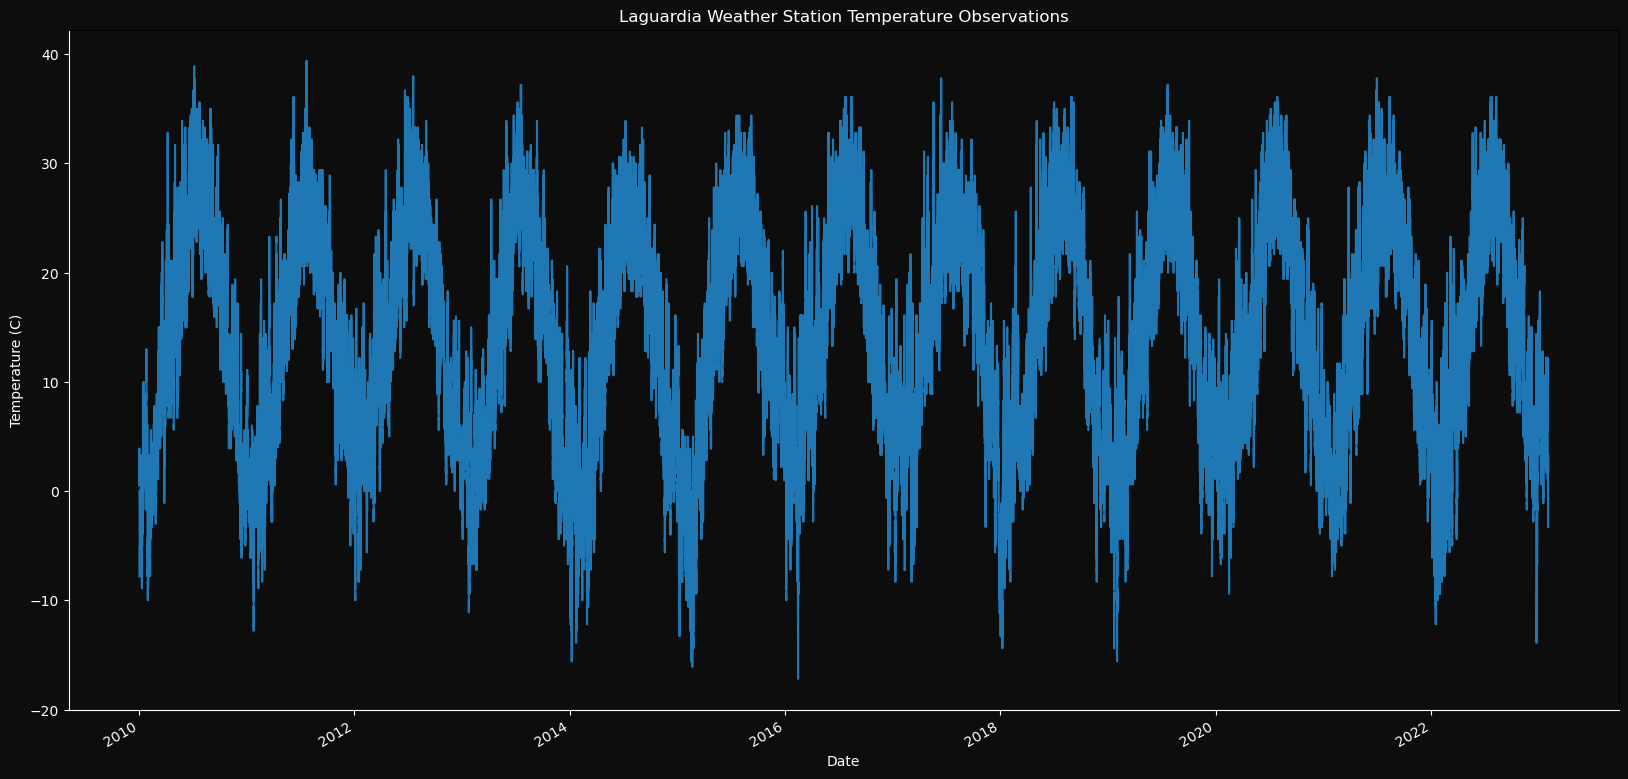

In [63]:
ax = weather_df[['DATE', 'temperature_c']].plot(
    x='DATE', y='temperature_c',
    xlabel='Date', ylabel="Temperature (C)",
    title="Laguardia Weather Station Temperature Observations",
    legend=False)

ax.set_facecolor("#0d0d0d")
fig = ax.get_figure()
fig.set_facecolor("#0d0d0d")
fig.set_size_inches((20,10))
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
ax.tick_params(axis='x', colors='white', rotation=30)
ax.tick_params(axis='y', colors='white')

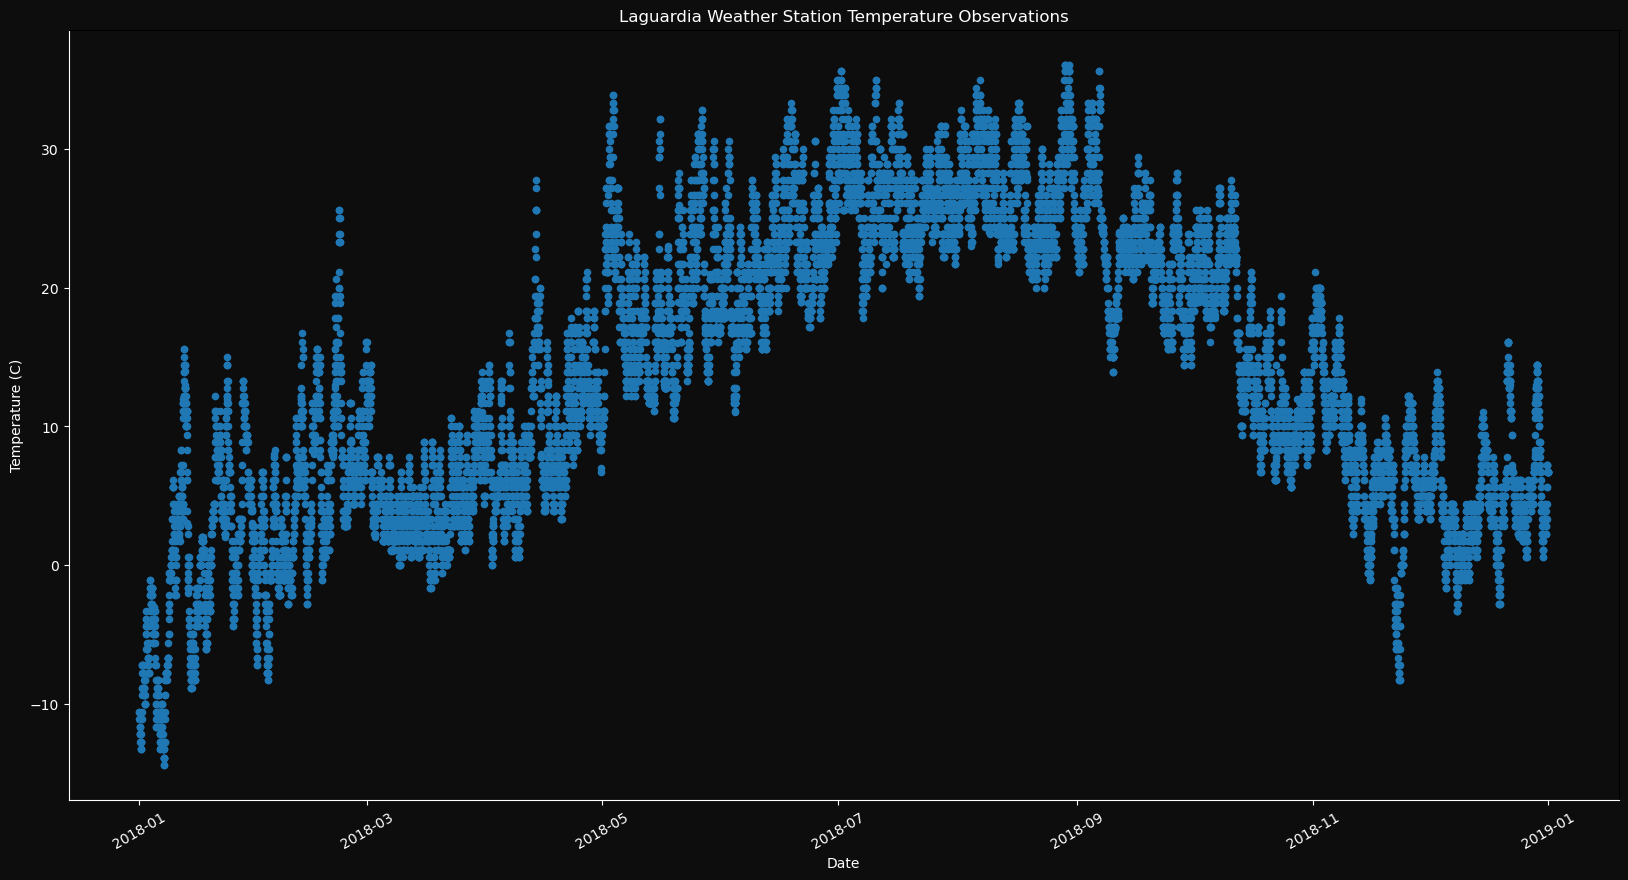

In [66]:


ax = weather_df[['DATE', 'temperature_c']]\
    [(weather_df['DATE']>=datetime.datetime(2018,1,1))
     &
     (weather_df['DATE']<datetime.datetime(2019,1,1))
     ].plot.scatter(
    x='DATE', y='temperature_c',
    xlabel='Date', ylabel="Temperature (C)",
    title="Laguardia Weather Station Temperature Observations",
    legend=False)

ax.set_facecolor("#0d0d0d")
fig = ax.get_figure()
fig.set_facecolor("#0d0d0d")
fig.set_size_inches((20,10))
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
ax.tick_params(axis='x', colors='white', rotation=30)
ax.tick_params(axis='y', colors='white')